### Import necessary packages

In [407]:
import pandas as pd
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.cm as cm

%matplotlib inline

In [408]:
%pwd

'C:\\Users\\naikn\\Desktop\\ADS'

In [409]:
%ls

 Volume in drive C is OS
 Volume Serial Number is C8B5-09AE

 Directory of C:\Users\naikn\Desktop\ADS

11/05/2020  05:07 PM    <DIR>          .
11/05/2020  05:07 PM    <DIR>          ..
11/05/2020  04:17 PM    <DIR>          .ipynb_checkpoints
11/05/2020  05:07 PM           146,416 Assignment_1.ipynb
11/04/2020  01:06 PM         2,606,354 Assignment1.ipynb
11/05/2020  03:23 PM             4,551 iris.data
11/05/2020  03:25 PM    <DIR>          Medium-master
11/05/2020  11:49 AM        23,715,344 Online Retail.xlsx
11/05/2020  10:26 AM            15,021 Wholesalecustomersdata.csv
               5 File(s)     26,487,686 bytes
               4 Dir(s)  378,521,423,872 bytes free


### Read data

In [410]:
df = pd.read_excel("Online Retail.xlsx")
print(df.shape)
df.head(3)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [411]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


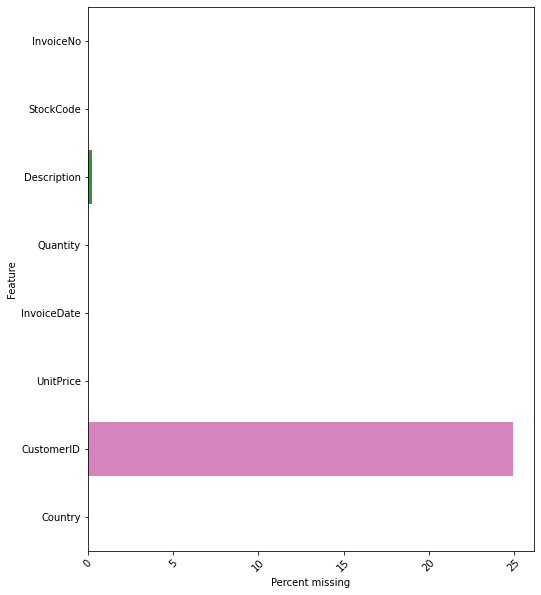

In [412]:
'''Calculate percentage null values for each column or feature'''

null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,10))
plt.xticks(rotation=45)
sns.barplot(x = "Percent missing",y ="Feature",data = null_vals,orient = "h")

In [413]:
'''Drop rows with any null values'''

df1 = df.dropna(subset = ["CustomerID","Description"])
df1.shape

(406829, 8)

In [414]:
'''Drop duplicated rows'''

df2 = df1.drop_duplicates()
print(df2.shape)
df2.head(2)

(401604, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [415]:
'''Select columns you need'''

df3 = df2 [['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
print(df3.shape)
df3.head(2)

(401604, 5)


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39


In [416]:
'''Create a total price column by multiplying quantity with unit price'''

df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']
print(df3.shape)
df3.head(2)

(401604, 6)


<ipython-input-416-4ba905cb56c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [417]:
'''Print out earliest and latest dates in the data'''

print('Min:{}; Max:{}'.format(df3["InvoiceDate"].min(), df3["InvoiceDate"].max()))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


In [418]:
'''Create a reference point for the analysis'''

current_date = dt.datetime(2011,12,10)
current_date

datetime.datetime(2011, 12, 10, 0, 0)

In [419]:
'''Calculate the aggregates" recency, frequency and, monetary. Recency tells you how many days since
last transaction for each customer, frequency tells you how frequently does a customer shop and,
monetary tells you the total shopping spending for each customer'''

df4 = df3.groupby(['CustomerID']).agg({ 'InvoiceDate': lambda x: (current_date - x.max()).days, 'InvoiceNo': 'count',
'TotalPrice': 'sum'})
df4.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency','TotalPrice': 'Monetary'}, inplace=True)
print(df4.shape)
df4.head(3)

(4372, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24


In [420]:
'''Remove rows with any zero values. This is to facilitate downstream pre-processing and avoid NaNs'''

df5 = df4[(df4 > 0).all(1)]
print(df5.shape)

(4284, 3)


### Data Preprocessing

In [421]:
'''The K-means clustering algorithm has a few key assumptions about the data: (1) data is not skewed, 
(2) features have the same mean and, (3) features have the same variance'''

df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


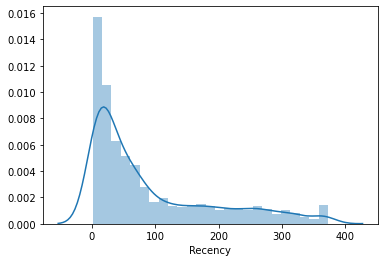

In [422]:
'''Are the data dimensions skewed?'''

sns.distplot(df5['Recency'])

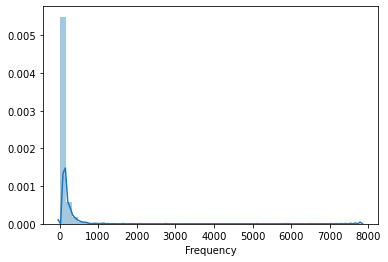

In [423]:
sns.distplot(df5['Frequency'])

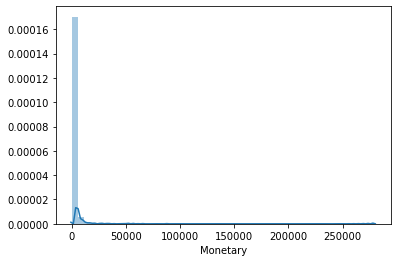

In [424]:
sns.distplot(df5['Monetary'])

In [425]:
'''Looks like the data is skewed. Maybe monetary is not, but the other two definitely are skewed. We log
transform the data to remove the skew. Add a constant to offset any negative values. '''

df6 = (np.log(df5 + 1))
print(df6.shape)
df6.head(3)

(4284, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1.098612,5.209486,8.368925
12348.0,4.330733,3.465736,7.494564
12349.0,2.944439,4.304065,7.472245


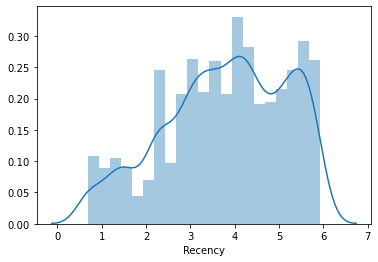

In [426]:
'''Has log transfors made any difference?'''

sns.distplot(df6['Recency'])

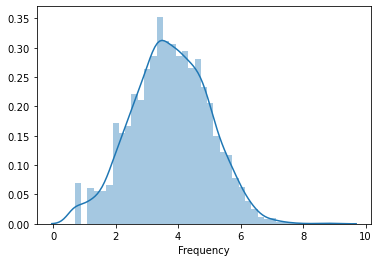

In [427]:
'''Has log transfors made any difference?'''

sns.distplot(df6['Frequency'])

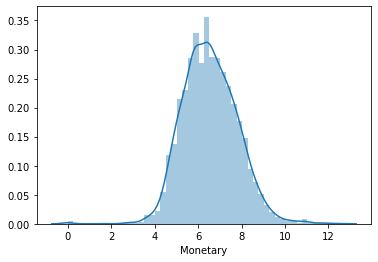

In [428]:
'''Has log transfors made any difference?'''

sns.distplot(df6['Monetary'])

In [429]:
'''Do scaling to make sure all dimensions have equal mean and variance'''

scaler = StandardScaler() 
scaler.fit(df6)
df7 = pd.DataFrame(scaler.transform(df6))
df7.columns = df6.columns
df7.describe()

,Recency,Frequency,Monetary
count,4.284000e+03,4.284000e+03,4.284000e+03
mean,-7.420114e-17,-2.576267e-16,-9.003069e-17
std,1.000117e+00,1.000117e+00,1.000117e+00
min,-2.257036e+00,-2.483041e+00,-5.244693e+00
25%,-6.530502e-01,-6.528544e-01,-6.740816e-01
50%,1.072168e-01,1.113110e-02,-5.693016e-02
75%,8.495844e-01,6.972361e-01,6.667453e-01
max,1.561702e+00,4.240374e+00,4.805312e+00


In [430]:
k_means = KMeans(n_clusters=2, random_state=1)

In [431]:
'''Let's see how this works:
Apply k-means on the preprocessed data and get cluster labels for each row'''

k_means.fit(df7)
clus_labels = k_means.labels_

In [432]:
'''Get cluster characteristics. Since we are interested in the original values,
we use the non-log transformed, non-standardized dataframe'''

df5_clus2 = df5.assign(Cluster = clus_labels)
print(df5_clus2.shape)
df5_clus2.head(2)

(4284, 4)


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347.0,2,182,4310.00,1
12348.0,75,31,1797.24,0


In [433]:
df5_clus2.groupby(['Cluster']).agg({ 'Recency': 'mean',
'Frequency': 'mean',
'Monetary': ['mean', 'count'],
}).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         140.0      25.0    426.0  2375
1          30.0     171.0   3516.0  1909

### K Means Clustering Algorithm

In [434]:
def random_centroids(df7, K):    
    centroids = []
    #Place K centroids at random locations
    for i in range(K):
        centroid = df7[rand.randint(0, 149)]
        centroids.append(centroid)
    return centroids

In [435]:

def assign_cluster(df7, centroids):
    assignments = []

    for data_point in df7:
        dist_point_clust = []

        for centroid in centroids:
            d_clust = np.linalg.norm(np.array(data_point) - np.array(centroid))
            dist_point_clust.append(d_clust)
        
        assignment = np.argmin(dist_point_clust)
        assignments.append(assignment)

    return assignments

In [436]:
def new_centroids(df7, centroids, assignments, K):
    new_centroids = []
    for i in range(K):
        pt_cluster = []
        for x in range(len(df7)):
                if (assignments[x] == i):
                    pt_cluster.append(df7[x])
        mean_c = np.mean(pt_cluster, axis=0)
        new_centroids.append(mean_c)

    return new_centroids

In [437]:
def sse(df7, assignments, centroids):
    errors = []
    
    for i in range(len(df7)):
        #get assigned centroid for each point
        centroid = centroids[assignments[i]]
    
        #compute the distance (error) between one point and its closest centroid
        error = np.linalg.norm(np.array(df7[i]) - np.array(centroid))
        
        #append squared error to the list of error
        errors.append(error**2)
        
    #and sum up all the errors
    sse = sum(errors)
    
    return sse

In [438]:
def kmeans_clustering(df7,K,max_iter = 100, tol = pow(10,-3) ):
    it = -1
    all_sse = []
    assignments = []
    
    #Place K centroids at random locations
    centroids = random_centroids(df7, K)

   
    #Until algorithm converges
    while (len(all_sse)<=1 or (it < max_iter and np.absolute(all_sse[it] - all_sse[it-1])/all_sse[it-1] >= tol)):
        it += 1
        #Assign all data points to the closest center
        assignments = assign_cluster(df7, centroids)
        
        #Compute the new centroids
        centroids = new_centroids(df7, centroids, assignments, K)
        
        #Compute SSE
        sse_kmeans = sse(df7, assignments, centroids)
        all_sse.append(sse_kmeans)        
        
     
    return (assignments, centroids, all_sse, it)

### Elbow Method

In [439]:
# Fit KMeans and calculate SSE for each *k*
ss_error = {}
for k in range(1, 20):
    k_means = KMeans(n_clusters=k, random_state=1)
    k_means.fit(df7)
    ss_error[k] = k_means.inertia_

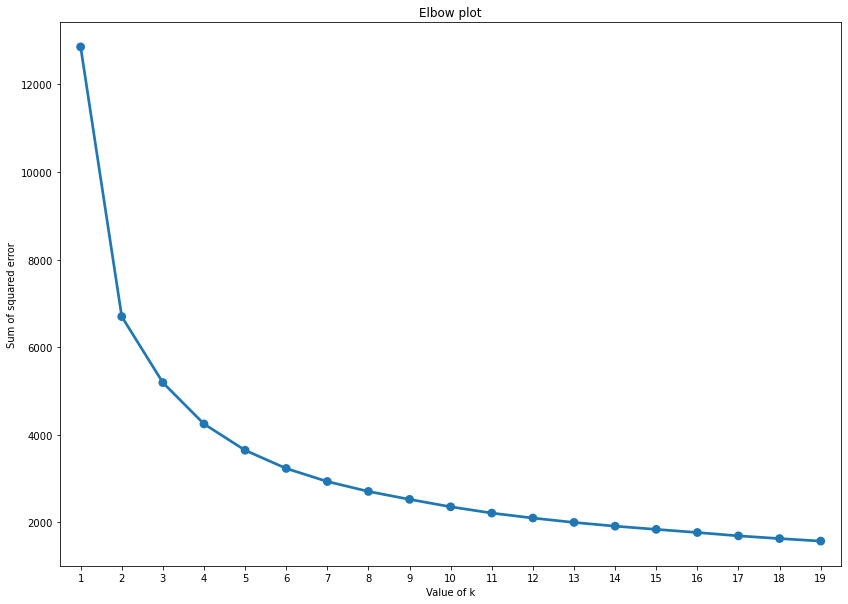

In [440]:
# Make elbow plot
plt.figure(figsize = (14,10))
plt.title('Elbow plot')
plt.xlabel('Value of k')
plt.ylabel('Sum of squared error')
sns.pointplot(x=list(ss_error.keys()), y=list(ss_error.values()))

### Silhoutte method 

For n_clusters = 2 The average silhouette_score is : 0.39941177036801495
For n_clusters = 3 The average silhouette_score is : 0.30330398022881494
For n_clusters = 4 The average silhouette_score is : 0.3116767522032755
For n_clusters = 5 The average silhouette_score is : 0.27803706051664806
For n_clusters = 6 The average silhouette_score is : 0.27408667045750995
For n_clusters = 7 The average silhouette_score is : 0.2647216629019396
For n_clusters = 8 The average silhouette_score is : 0.25836154319886856
For n_clusters = 10 The average silhouette_score is : 0.2605694368243357
For n_clusters = 12 The average silhouette_score is : 0.2658911148121639
For n_clusters = 14 The average silhouette_score is : 0.2524188055421747


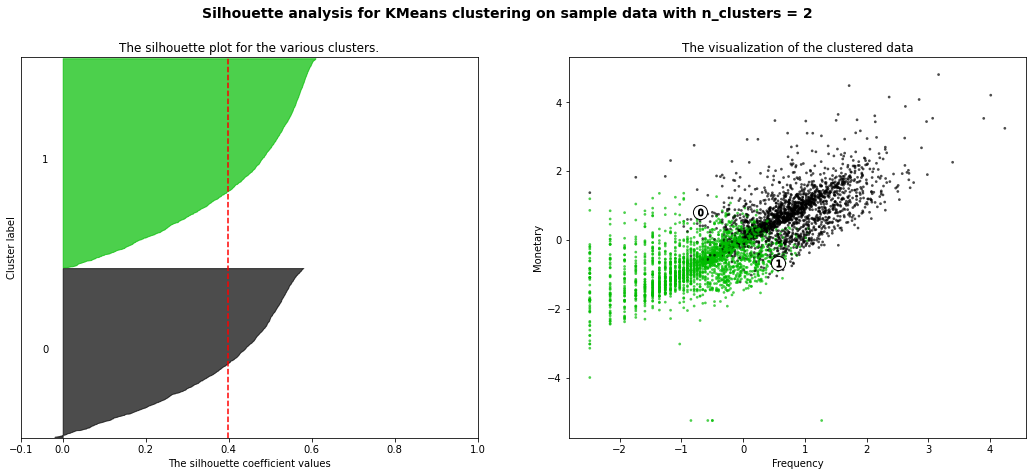

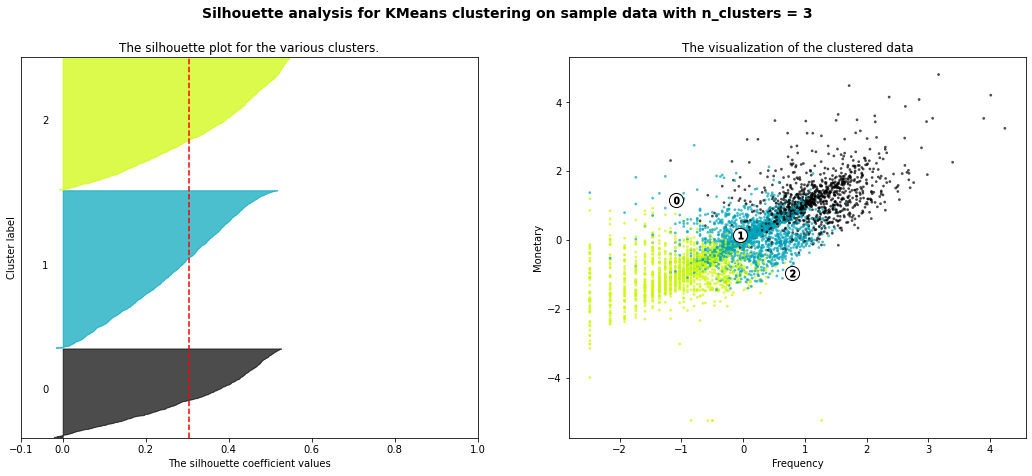

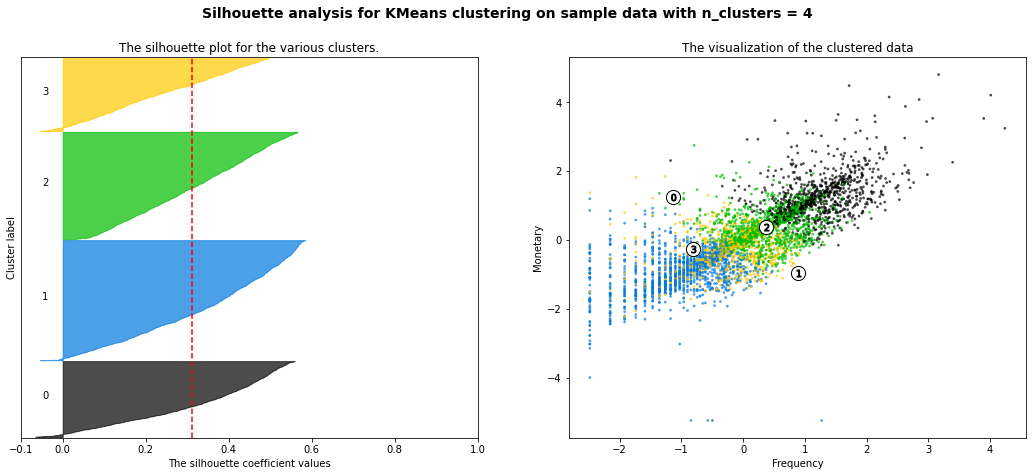

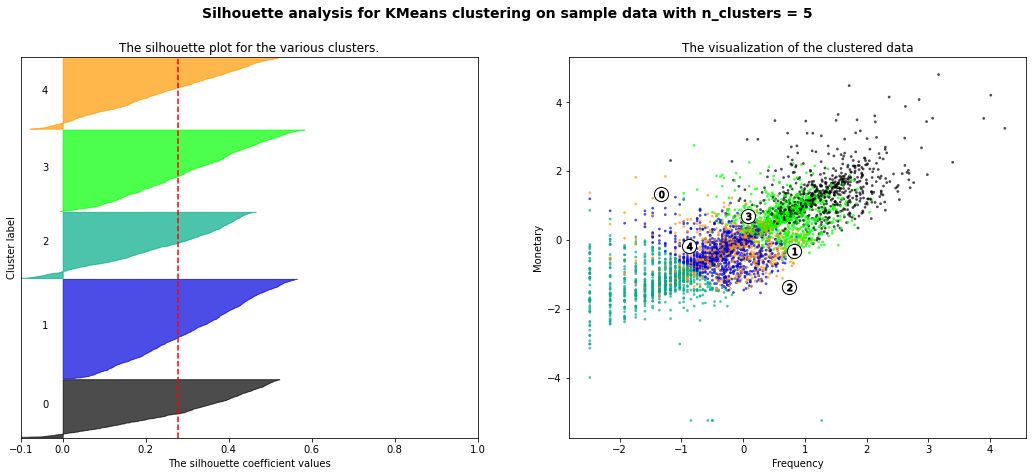

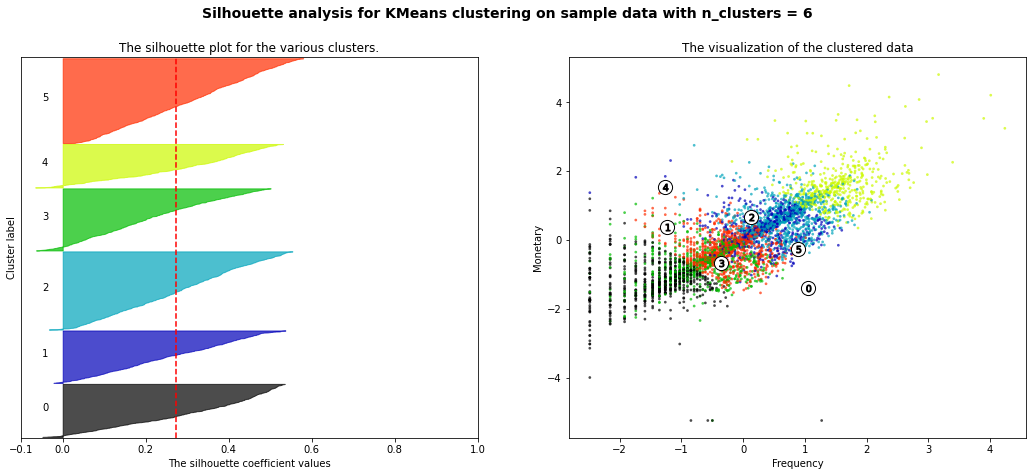

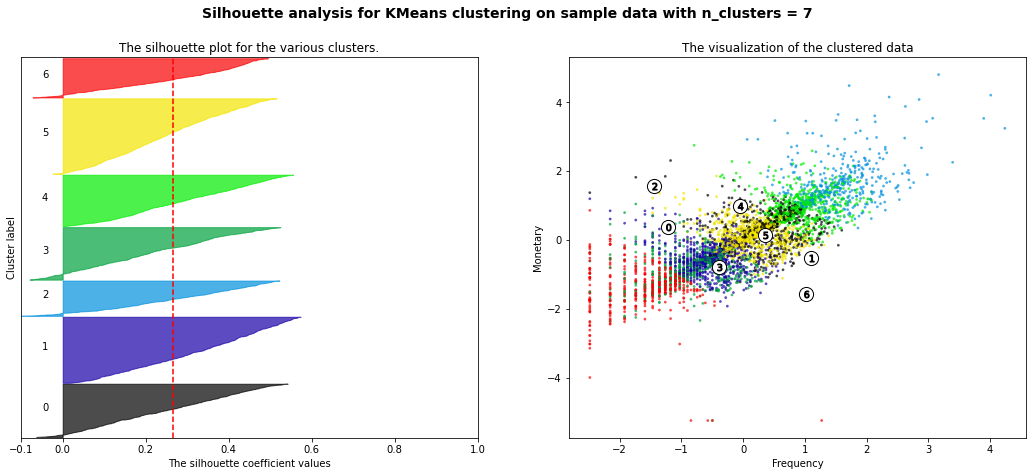

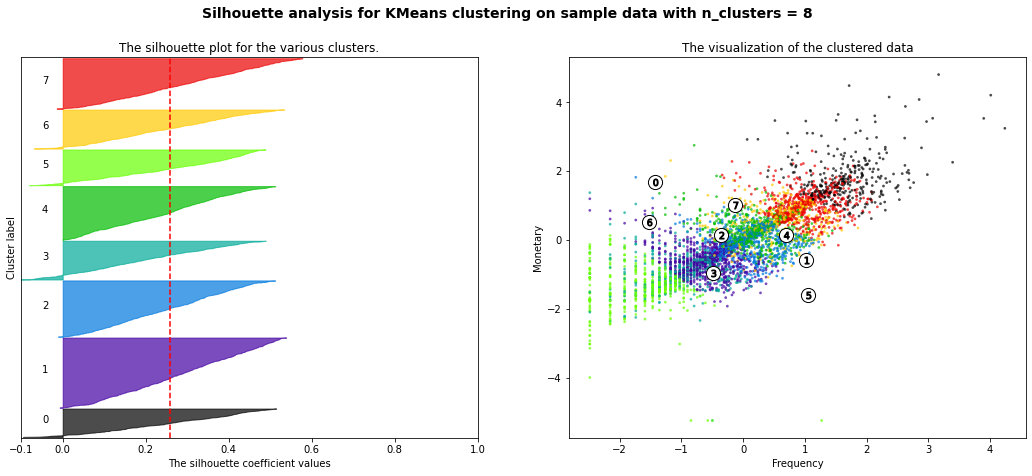

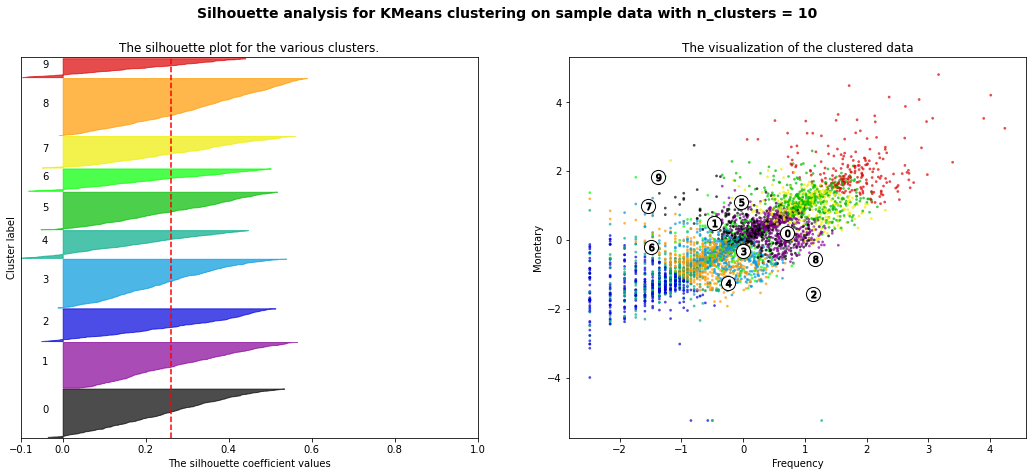

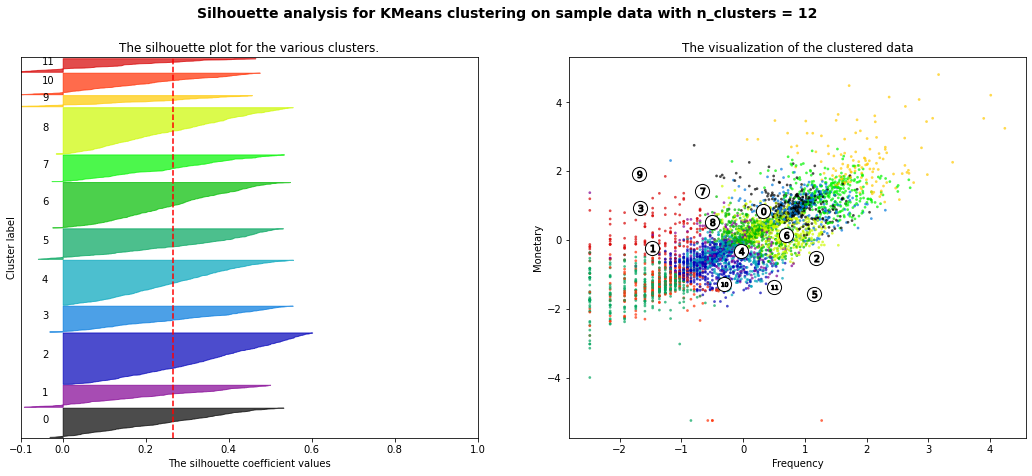

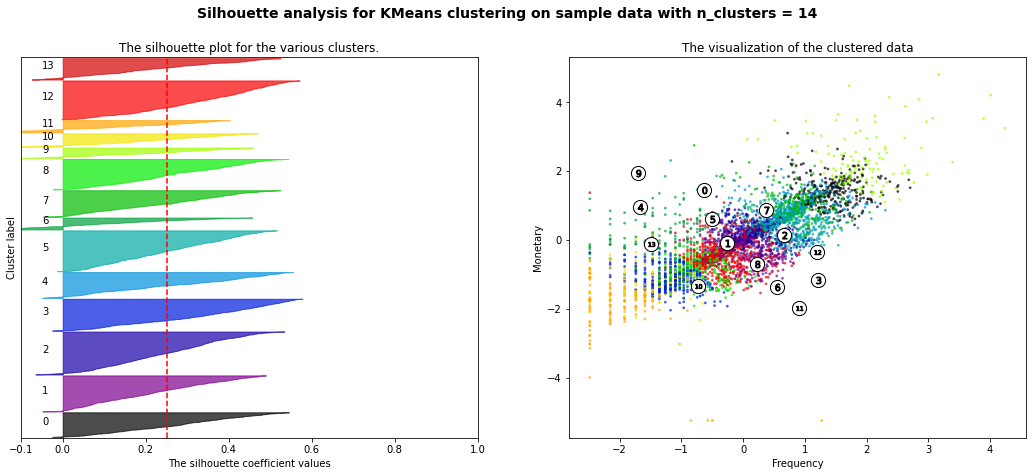

In [441]:
'''Looks like k = 2 is a good solution. But always, explore other values of K around the elbow.
Finally disucss several solutions with stakeholders to see which makes most sense !
Here, we also use Silhoutte plots and scores'''

# Number of clusters confirmation by silhoutte scores
X = df7
range_n_clusters = [2, 3, 4, 5, 6,7,8,10,12,14]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X["Frequency"], X["Monetary"], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Monetary")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [442]:
'''Looks like k = 2 has the best Silhoutte score. So let's pick k = 2 and do some interesting visualizations.
Add cluster column to the pre-processed data'''

df8 = df7.assign(Cluster = clus_labels)
print(df8.shape)
df8.head(3)

(4284, 4)


,Recency,Frequency,Monetary,Cluster
0,-1.961044,1.188514,1.462077,1
1,0.398422,-0.229066,0.761373,0
2,-0.613581,0.452453,0.743487,1


In [443]:
'''Use melt to transform the dataframe (not the data itself)'''

df8_melt = pd.melt(df8.reset_index(), id_vars=['Cluster'],
value_vars=['Recency', 'Frequency', 'Monetary'], var_name='Attribute',
value_name='Value')

In [444]:
df8_melt.head(3)

,Cluster,Attribute,Value
0,1,Recency,-1.961044
1,0,Recency,0.398422
2,1,Recency,-0.613581


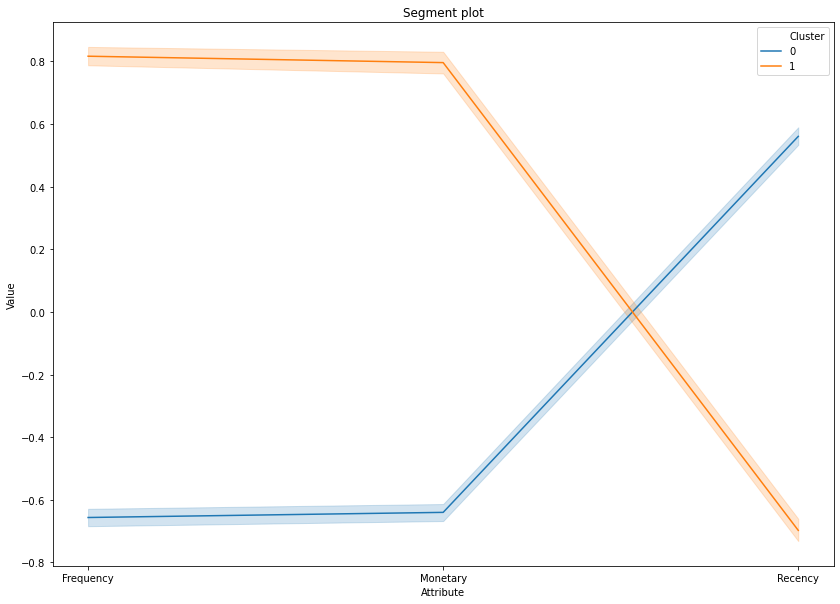

In [445]:
'''Visualize segment characteristics to understand the clusters better'''

plt.figure(figsize = (14,10))
plt.title('Segment plot') 
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=df8_melt)

### Relative feature importances w.r.t clusters

In [446]:
cluster_avg = df5_clus2.groupby(['Cluster']).mean()
cluster_avg

,Recency,Frequency,Monetary
Cluster,,,
0,139.509053,25.017684,425.889904
1,29.923520,171.260870,3516.026580


In [447]:
population_avg = df5.mean()
population_avg

Recency        90.676471
Frequency      90.185341
Monetary     1802.890585
dtype: float64

In [448]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,0.54,-0.72,-0.76
1,-0.67,0.90,0.95


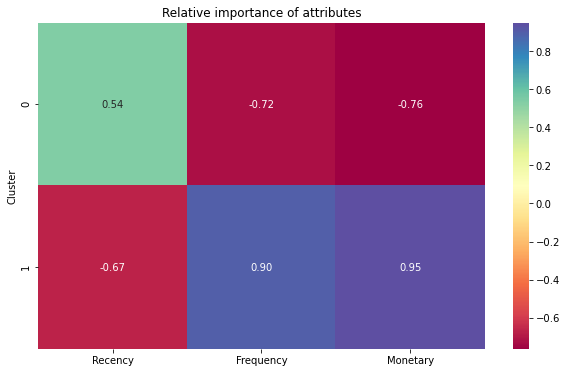

In [449]:
plt.figure(figsize=(10, 6))
plt.title('Relative importance of attributes') 
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Spectral')